Step 1: Import Necessary Libraries

In [3]:
from tensorflow.keras import backend as K

# Clear the session before training
K.clear_session()

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import random
import matplotlib.pyplot as plt

Step 2: Load and Preprocess the MNIST Dataset
* The MNIST dataset consists of 28x28 grayscale images, so we need to reshape and scale the data.

In [24]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

# Add a channel dimension to the grayscale images (from 28x28 to 28x28x1)
input_train = input_train.reshape(-1, 28, 28, 1)
input_test = input_test.reshape(-1, 28, 28, 1)

# Preprocess data: Resize MNIST images from 28x28x1 to 32x32x1
input_train_resized = np.array([tf.image.resize(img, (32, 32)) for img in input_train])
input_test_resized = np.array([tf.image.resize(img, (32, 32)) for img in input_test])

# Normalize pixel values to be between 0 and 1
input_train_resized = input_train_resized.astype('float32') / 255
input_test_resized = input_test_resized.astype('float32') / 255

# Convert labels to one-hot encoded vectors
target_train = to_categorical(target_train, 10)
target_test = to_categorical(target_test, 10)

# Load VGG16 model with pre-trained weights from ImageNet and exclude top layers
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [25]:
# Freeze all layers of VGG16
for layer in vgg16.layers:
    layer.trainable = False

# Add custom layers for MNIST classification
model = models.Sequential()
model.add(layers.Conv2D(3, (3, 3), padding='same', input_shape=(32, 32, 1)))  # Convert grayscale to 3 channels
model.add(vgg16)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [26]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)
datagen.fit(input_train_resized)

In [31]:
# Set seed for reproducibility
random.seed(42)

# Determine the number of samples to use (10% of the training set)
num_samples = int(0.1 * input_train_resized.shape[0])

# Get random indices
indices = random.sample(range(input_train_resized.shape[0]), num_samples)

# Subset the data
input_train_subset = input_train_resized[indices]
target_train_subset = target_train[indices]

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [32]:
# Train the model with the subset and early stopping
history_subset = model.fit(input_train_subset, target_train_subset, epochs=5, 
                            batch_size=64, validation_data=(input_test_resized, target_test),
                            callbacks=[early_stopping])


Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9428 - loss: 0.1738 - val_accuracy: 0.9485 - val_loss: 0.1673
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9546 - loss: 0.1359 - val_accuracy: 0.9534 - val_loss: 0.1504
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9617 - loss: 0.1240 - val_accuracy: 0.9566 - val_loss: 0.1352
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.9697 - loss: 0.1038 - val_accuracy: 0.9554 - val_loss: 0.1350
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.9707 - loss: 0.0949 - val_accuracy: 0.9541 - val_loss: 0.1428


In [34]:
# Test model and evaluate
score_subset = model.evaluate(input_test_resized, target_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 233ms/step - accuracy: 0.9469 - loss: 0.1612


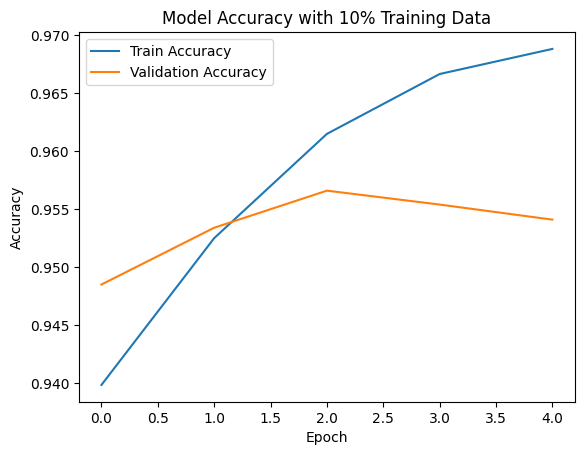

In [35]:

# Plot results
plt.plot(history_subset.history['accuracy'], label='Train Accuracy')
plt.plot(history_subset.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with 10% Training Data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [36]:
# Print evaluation score
print(f"Test loss: {score_subset[0]}, Test accuracy: {score_subset[1]}")

Test loss: 0.1428280472755432, Test accuracy: 0.9541000127792358


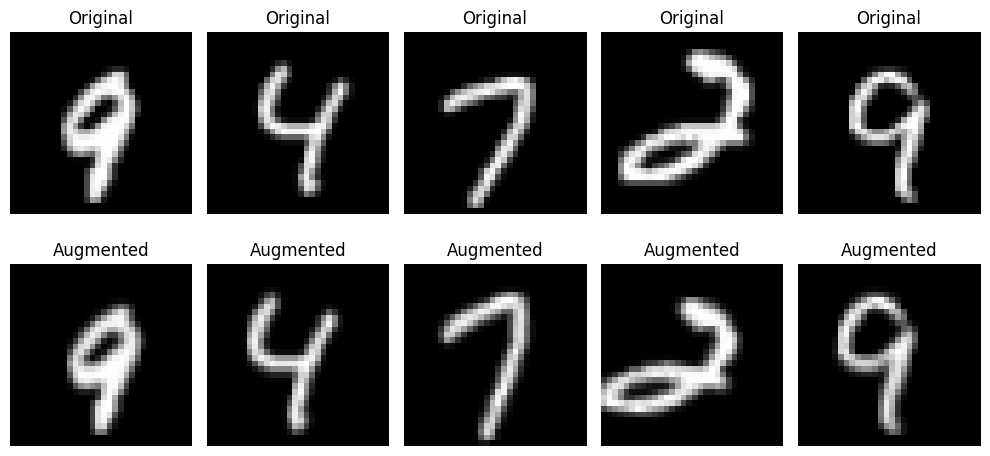

In [37]:
# Visualize Original vs Augmented Images
# Get a few examples from the subset
num_visuals = 5  # Number of images to visualize
original_examples = input_train_subset[:num_visuals]
augmented_examples = np.array([datagen.random_transform(img) for img in original_examples])

# Create a plot to compare original vs augmented images
plt.figure(figsize=(10, 5))
for i in range(num_visuals):
    # Original images
    plt.subplot(2, num_visuals, i + 1)
    plt.imshow(original_examples[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Original')

    # Augmented images
    plt.subplot(2, num_visuals, i + 1 + num_visuals)
    plt.imshow(augmented_examples[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Augmented')

plt.tight_layout()
plt.show()